# Hierarchical Bayseian Model



In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pymc3 as pm
import theano
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\kethan\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load data
sorted_data_full = pd.read_csv("districts.csv", parse_dates=["Date"], infer_datetime_format=True, dayfirst=True)

In [3]:
#No of rows and columns in sorted_data_full
print("Number of Rows and Columns in sorted_data_full", sorted_data_full.shape)

Number of Rows and Columns in sorted_data_full (238288, 8)


In [4]:
#Print the first 5 rows of the dataset sorted_data_full
print("First 5 rows of dataset sorted_data_full")
sorted_data_full.head()

First 5 rows of dataset sorted_data_full


,Date,State,District,Confirmed,Recovered,Deceased,Other,Tested
0,2020-04-26,Andaman and Nicobar Islands,Unknown,33,11,0,0,2679.0
1,2020-04-26,Andhra Pradesh,Anantapur,53,14,4,0,NaN
2,2020-04-26,Andhra Pradesh,Chittoor,73,13,0,0,NaN
3,2020-04-26,Andhra Pradesh,East Godavari,39,12,0,0,NaN
4,2020-04-26,Andhra Pradesh,Guntur,214,29,8,0,NaN


In [5]:
#Print the last 5 rows of the dataset sorted_data_full
print("Last 5 rows of dataset sorted_data_full")
sorted_data_full.tail()

Last 5 rows of dataset sorted_data_full


,Date,State,District,Confirmed,Recovered,Deceased,Other,Tested
238283,2021-05-02,West Bengal,Purba Bardhaman,20231,16668,111,0,NaN
238284,2021-05-02,West Bengal,Purba Medinipur,28445,24202,299,0,NaN
238285,2021-05-02,West Bengal,Purulia,14067,10893,65,0,NaN
238286,2021-05-02,West Bengal,South 24 Parganas,54352,45764,800,0,NaN
238287,2021-05-02,West Bengal,Uttar Dinajpur,10441,8325,93,0,NaN


In [6]:
# Checking the datatypes of all the columns in sorted_data_full
print('Datatypes of all columns in sorted_data_full \n\n', sorted_data_full.dtypes)
#sorted_data_full.isnull().sum()

Datatypes of all columns in sorted_data_full 

 Date         datetime64[ns]
State                object
District             object
Confirmed             int64
Recovered             int64
Deceased              int64
Other                 int64
Tested              float64
dtype: object


In [7]:
# Function to split the data based on the given districts
def daily(df, district):
    temp1 = df.loc[df["District"] == district[0]].copy()
    for i in range(1, len(district)):
        temp = df.loc[df["District"] == district[i]].copy()
        temp1 = temp.append(temp1)

    return temp1

In [8]:
dist_l = ['Bengaluru Urban','Chennai','Mumbai','Thiruvananthapuram','Delhi']

In [9]:
# Dropping irrevelant columns in sorted_data_full
sorted_data_full = sorted_data_full.set_index(sorted_data_full["Date"]).sort_index()
sorted_data_full = sorted_data_full.drop(['Other','Tested','Recovered','Deceased'], axis=1)



In [10]:
sorted_data = sorted_data_full.loc[sorted_data_full['Date'] <= '2021-05-02']
sorted_data = daily(sorted_data, dist_l)
sorted_data = sorted_data.reset_index(drop = True)


In [11]:
sorted_data

,Date,State,District,Confirmed
0,2020-04-26,Delhi,Delhi,2918
1,2020-04-27,Delhi,Delhi,3108
2,2020-04-28,Delhi,Delhi,3314
3,2020-04-29,Delhi,Delhi,3439
4,2020-04-30,Delhi,Delhi,3515
...,...,...,...,...
1855,2021-04-28,Karnataka,Bengaluru Urban,710347
1856,2021-04-29,Karnataka,Bengaluru Urban,729984
1857,2021-04-30,Karnataka,Bengaluru Urban,756740
1858,2021-05-01,Karnataka,Bengaluru Urban,776093


In [12]:
# Filter out data with less than 500 cases
sorted_data = sorted_data[sorted_data["Confirmed"] >= 500]
sorted_data = sorted_data.reset_index(drop = True)

# Get final list of districts 
districts = sorted_data["District"].unique()
n_districts = len(districts)

# Create a new column with the number of days since first infection
district_first_dates = {d: sorted_data[sorted_data["District"] == d].index.min() for d in districts}
sorted_data["100_cases"] = sorted_data.apply(lambda x: district_first_dates[x.District], axis=1)
sorted_data["days_since_100_cases"] = (sorted_data.index - sorted_data["100_cases"])

In [13]:
# Dataset after data cleaning
print("Dataset after data cleaning \n\n")
sorted_data = sorted_data.reset_index(drop = True)
sorted_data

Dataset after data cleaning 




,Date,State,District,Confirmed,100_cases,days_since_100_cases
0,2020-04-26,Delhi,Delhi,2918,0,0
1,2020-04-27,Delhi,Delhi,3108,0,1
2,2020-04-28,Delhi,Delhi,3314,0,2
3,2020-04-29,Delhi,Delhi,3439,0,3
4,2020-04-30,Delhi,Delhi,3515,0,4
...,...,...,...,...,...,...
1737,2021-04-28,Karnataka,Bengaluru Urban,710347,1414,323
1738,2021-04-29,Karnataka,Bengaluru Urban,729984,1414,324
1739,2021-04-30,Karnataka,Bengaluru Urban,756740,1414,325
1740,2021-05-01,Karnataka,Bengaluru Urban,776093,1414,326


In [14]:
# Training Data from 2020-04-26 to 2021-02-28
print("Training Data from 2020-04-26 to 2021-04-25 \n\n")
sorted_data_train = sorted_data.loc[sorted_data['Date'] <= '25-04-2021']
sorted_data_train = sorted_data_train.reset_index(drop = True)
sorted_data_train

Training Data from 2020-04-26 to 2021-04-25 




,Date,State,District,Confirmed,100_cases,days_since_100_cases
0,2020-04-26,Delhi,Delhi,2918,0,0
1,2020-04-27,Delhi,Delhi,3108,0,1
2,2020-04-28,Delhi,Delhi,3314,0,2
3,2020-04-29,Delhi,Delhi,3439,0,3
4,2020-04-30,Delhi,Delhi,3515,0,4
...,...,...,...,...,...,...
1702,2021-04-21,Karnataka,Bengaluru Urban,583675,1414,316
1703,2021-04-22,Karnataka,Bengaluru Urban,598919,1414,317
1704,2021-04-23,Karnataka,Bengaluru Urban,615581,1414,318
1705,2021-04-24,Karnataka,Bengaluru Urban,632923,1414,319


In [15]:
# Testing Data from 2021-03-01
print("Testing Data from 2021-04-25 to 2021-05-02 \n\n")
sorted_data_test = sorted_data.loc[(sorted_data['Date'] > '25-04-2021') & (sorted_data['Date'] <= '2021-05-02')]
sorted_data_test = sorted_data_test.reset_index(drop = True)
sorted_data_test

Testing Data from 2021-04-25 to 2021-05-02 




,Date,State,District,Confirmed,100_cases,days_since_100_cases
0,2021-04-26,Delhi,Delhi,1047916,0,365
1,2021-04-27,Delhi,Delhi,1072065,0,366
2,2021-04-28,Delhi,Delhi,1098051,0,367
3,2021-04-29,Delhi,Delhi,1122286,0,368
4,2021-04-30,Delhi,Delhi,1149333,0,369
5,2021-05-01,Delhi,Delhi,1174552,0,370
6,2021-05-02,Delhi,Delhi,1194946,0,371
7,2021-04-26,Kerala,Thiruvananthapuram,132074,372,291
8,2021-04-27,Kerala,Thiruvananthapuram,134966,372,292
9,2021-04-28,Kerala,Thiruvananthapuram,138176,372,293


In [16]:
# Logistic regression function
def logistic(K, r, t, C_0):
    A = (K-C_0)/C_0
    return K / (1 + A * np.exp(-r * t))

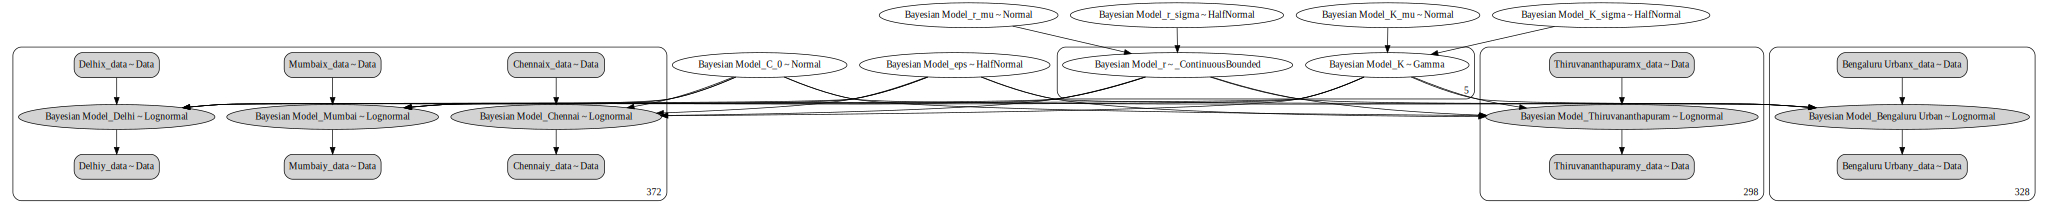

In [17]:
# Model fitting using pymc3
bayesian_model = pm.Model("Bayesian Model")
with bayesian_model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)

    # Intercept
    C_0 = pm.Normal("C_0", mu=1000, sigma=100)

    # Growth rate
    r_mu = pm.Normal("r_mu", mu=0.4, sigma=0.1)
    r_sigma = pm.HalfNormal("r_sigma", 0.5)
    r = BoundedNormal("r", mu=r_mu, sigma=r_sigma, shape=n_districts)

    # Total number of cases
    K_mu = pm.Normal("K_mu", mu=1000000, sigma=1000000)
    K_sigma = pm.HalfNormal("K_sigma", 50000)
    K = pm.Gamma("K", mu=K_mu, sigma=K_sigma, shape=n_districts)

    # Likelihood error
    eps = pm.HalfNormal("eps")

    for i, district in enumerate(districts):

        df_district = sorted_data.loc[lambda x: (x.District == district)]

        # Loading train data
        t = pm.Data(district + "x_data", df_district['days_since_100_cases'])
        confirmed_cases = pm.Data(district + "y_data", df_district['Confirmed'])

        # Logistic regression
        growth = logistic(K[i], r[i], t, C_0)

        # Likelihood using Lognormal distribution
        pm.Lognormal(district, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
    
# Graphical representation of the model
pm.model_to_graphviz(bayesian_model)

In [18]:
# Test that the model does not produce NaNs.
for RV in bayesian_model.basic_RVs:
    print(RV.name, RV.logp(bayesian_model.test_point))

Bayesian Model_C_0 -5.524108719192764
Bayesian Model_r_mu 1.3836465597893728
Bayesian Model_r_sigma_log__ -0.7698925914732455
Bayesian Model_r_lowerbound__ -5.654866776461628
Bayesian Model_K_mu -14.734449091168948
Bayesian Model_K_sigma_log__ -0.7698925914732442
Bayesian Model_K_log__ 11.51226231942843
Bayesian Model_eps_log__ -0.7698925914732455
Bayesian Model_Delhi -5913.096865032172
Bayesian Model_Thiruvananthapuram -5814.029361806982
Bayesian Model_Mumbai -5828.45754945639
Bayesian Model_Chennai -6244.9032106031955
Bayesian Model_Bengaluru Urban -5458.275234298711


In [19]:
with bayesian_model:
    # NUTS sampler for drawing samples.
    trace = pm.sample(draws = 50, tune=50, chains=1, cores=4, target_accept=.9)
    #trace = pm.sample()

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Bayesian Model_eps, Bayesian Model_K, Bayesian Model_K_sigma, Bayesian Model_K_mu, Bayesian Model_r, Bayesian Model_r_sigma, Bayesian Model_r_mu, Bayesian Model_C_0]
Sampling chain 0, 0 divergences: 100%|█████████████████████████████████████████████| 100/100 [1:51:25<00:00, 66.86s/it]
C:\Users\kethan\anaconda3\lib\site-packages\pymc3\sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [20]:
with bayesian_model:
    for district in districts:
        
        # Sample posterior predicting
        df_district = sorted_data.loc[lambda x: (x.District == district)]
        x_data = np.arange(0, len(df_district))
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({district + "x_data": x_data})
        pm.set_data({district + "y_data": y_data})
        
    ppc_hierarchical = pm.sample_posterior_predictive(trace, samples = 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:43<00:00,  6.12it/s]


In [21]:
def predicted_dataframe(hbm_train, hbm_test, y_pred, district):
    
    df_district_train = hbm_train.loc[lambda x: (x.District == district)]
    df_district_test = hbm_test.loc[lambda x: (x.District == district)]
    df_district_train = df_district_train.reset_index(drop = True)
    df_district_test = df_district_test.reset_index(drop = True)
    # Splitting training and tesing data
    fit_data = pd.DataFrame(y_pred["Bayesian Model_" + district])
    
    new_df_train = pd.DataFrame(columns = ['Predicted Confirmed']) 
    for i in range(0, len(df_district_train)):
        new_df_train = new_df_train.append({"Predicted Confirmed":np.mean(fit_data[i])}, ignore_index=True)
    new_df_train = new_df_train.astype({"Predicted Confirmed": int})
    new_df_train = new_df_train.reset_index(drop = True)
    
    new_df_test = pd.DataFrame(columns = ['Predicted Confirmed']) 
    for i in range(len(df_district_train), (len(df_district_train) + len(df_district_test))):
        new_df_test = new_df_test.append({"Predicted Confirmed":np.mean(fit_data[i])}, ignore_index=True)
    new_df_test = new_df_test.astype({"Predicted Confirmed": int})
    new_df_test = new_df_test.reset_index(drop = True)
    
    #Creating new dataframe for actual and predicted values
    predicted_df_hbm = pd.DataFrame(columns = ['Date', 'Actual Confirmed', 'Predicted Confirmed', 'Absolute Error', 'Accuracy', '% of incorrect prediction']) 
    
    #Extracting values according to position
    predicted_df_hbm["Date"] = df_district_test['Date']
    predicted_df_hbm["Actual Confirmed"] = df_district_test['Confirmed']
    predicted_df_hbm["Predicted Confirmed"] = new_df_test['Predicted Confirmed']
    predicted_df_hbm["Absolute Error"] = (predicted_df_hbm['Actual Confirmed'] - predicted_df_hbm['Predicted Confirmed']).map(abs)
    predicted_df_hbm["Accuracy"] = (1 - (predicted_df_hbm['Absolute Error']/predicted_df_hbm['Actual Confirmed'] ))*100
    predicted_df_hbm['% of incorrect prediction'] = (predicted_df_hbm['Absolute Error']/predicted_df_hbm['Actual Confirmed'])*100    
    
    return new_df_train, new_df_test, predicted_df_hbm, district

In [22]:
new_df_train_ben, new_df_test_ben, predicted_df_hbm_ben, district_ben = predicted_dataframe(sorted_data_train, sorted_data_test, ppc_hierarchical, 'Bengaluru Urban')

C:\Users\kethan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Confirmed'>

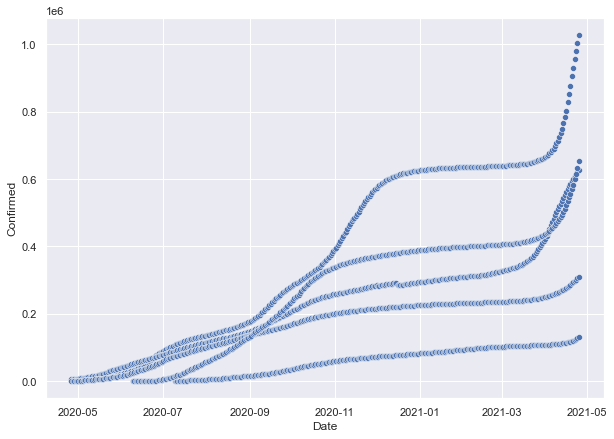

In [23]:
sns.set(rc={'figure.figsize':(10,7)})
sns.scatterplot(sorted_data_train['Date'], sorted_data_train['Confirmed'])


In [24]:
# Plotting traind data
def plot_hbm_train(hbm_train, y_fit, district):
    
    df_district_train = hbm_train.loc[lambda x: (x.District == district)]
    plt.title(district + " - Best Fit training data") 
    plt.xlabel('Date') 
    plt.ylabel('Confirmed Cases') 
    plt.plot(df_district_train['Date'], df_district_train['Confirmed'], color="red")
    plt.plot(df_district_train['Date'], y_fit, color = 'blue')
    #plt.yscale("log")
    plt.show()
    

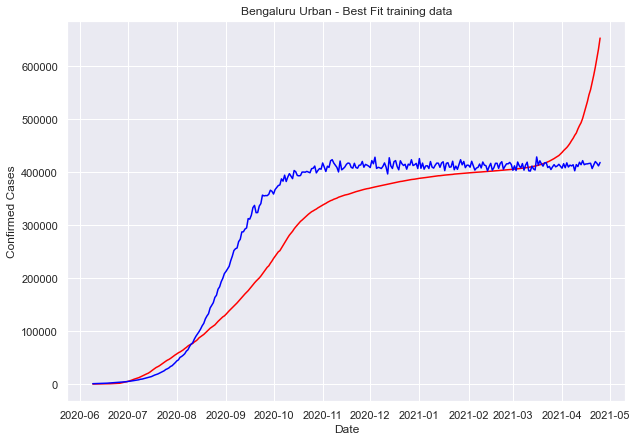

In [25]:
plot_hbm_train(sorted_data_train, new_df_train_ben, 'Bengaluru Urban')

In [26]:
print("Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in ", district_ben)
predicted_df_hbm_ben.reset_index(drop = True)

Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in  Bengaluru Urban


,Date,Actual Confirmed,Predicted Confirmed,Absolute Error,Accuracy,% of incorrect prediction
0,2021-04-26,670201,415909,254292,62.057353,37.942647
1,2021-04-27,687751,416016,271735,60.489334,39.510666
2,2021-04-28,710347,413673,296674,58.235341,41.764659
3,2021-04-29,729984,421709,308275,57.769622,42.230378
4,2021-04-30,756740,408998,347742,54.047361,45.952639
5,2021-05-01,776093,419762,356331,54.086559,45.913441
6,2021-05-02,797292,408088,389204,51.184259,48.815741


In [27]:
# Plotting test data
def plot_hbm_test(hbm_test, y_pred, district):
    
    df_district_test = hbm_test.loc[lambda x: (x.District == district)]
    plt.title( district + " - Actual vs Predicted values for Confirmed Cases") 
    plt.xlabel('Date') 
    plt.ylabel('Confirmed Cases') 
    plt.plot(df_district_test['Date'], df_district_test['Confirmed'], color="red")
    plt.plot(df_district_test['Date'], y_pred, color = 'blue')
    #plt.yscale("log")
    plt.show()

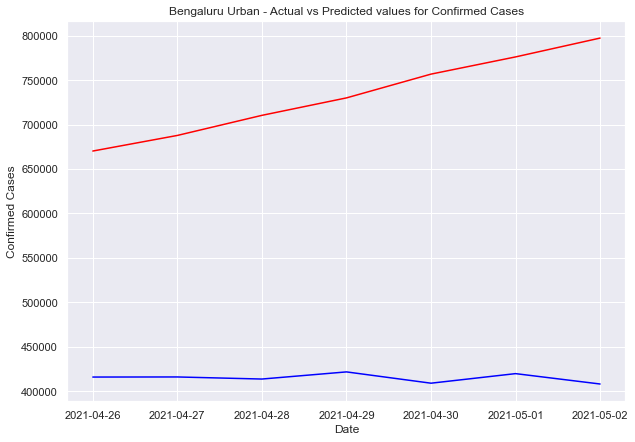

In [28]:
plot_hbm_test(sorted_data_test, new_df_test_ben, 'Bengaluru Urban')

 # Delhi

In [29]:
new_df_train_del, new_df_test_del, predicted_df_hbm_del, district_del = predicted_dataframe(sorted_data_train, sorted_data_test, ppc_hierarchical, 'Delhi')

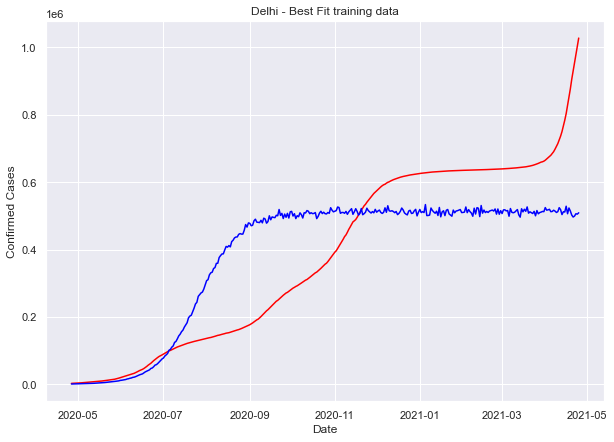

In [30]:
plot_hbm_train(sorted_data_train, new_df_train_del, 'Delhi')

In [31]:
print("Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in ", district_del)
predicted_df_hbm_del.reset_index(drop = True)

Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in  Delhi


,Date,Actual Confirmed,Predicted Confirmed,Absolute Error,Accuracy,% of incorrect prediction
0,2021-04-26,1047916,507530,540386,48.432317,51.567683
1,2021-04-27,1072065,518282,553783,48.344270,51.655730
2,2021-04-28,1098051,513189,584862,46.736354,53.263646
3,2021-04-29,1122286,508049,614237,45.269120,54.730880
4,2021-04-30,1149333,505572,643761,43.988296,56.011704
5,2021-05-01,1174552,517715,656837,44.077657,55.922343
6,2021-05-02,1194946,496232,698714,41.527567,58.472433


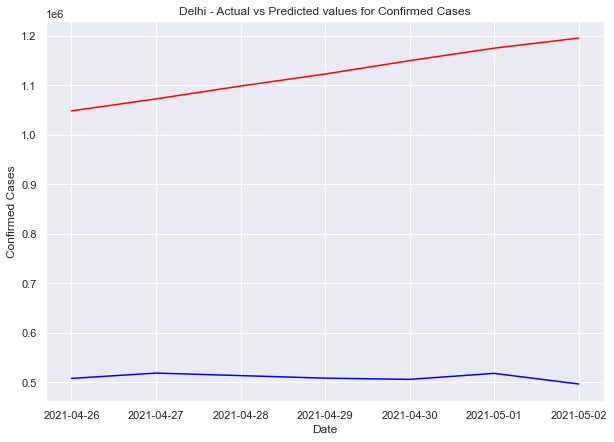

In [32]:
plot_hbm_test(sorted_data_test, new_df_test_del, 'Delhi')

# Thiruvananthapuram

In [33]:
new_df_train_th, new_df_test_th, predicted_df_hbm_th, district_th = predicted_dataframe(sorted_data_train, sorted_data_test, ppc_hierarchical, 'Thiruvananthapuram')

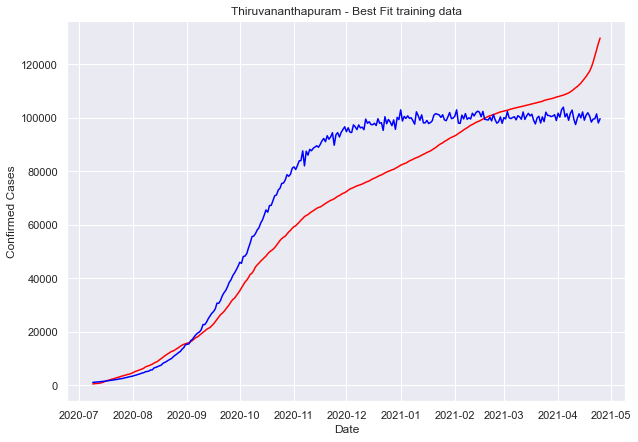

In [34]:
plot_hbm_train(sorted_data_train, new_df_train_th, 'Thiruvananthapuram')

In [35]:
print("Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in", district_th)
predicted_df_hbm_th.reset_index(drop = True)

Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in Thiruvananthapuram


,Date,Actual Confirmed,Predicted Confirmed,Absolute Error,Accuracy,% of incorrect prediction
0,2021-04-26,132074,100978,31096,76.455623,23.544377
1,2021-04-27,134966,101143,33823,74.939614,25.060386
2,2021-04-28,138176,101112,37064,73.176239,26.823761
3,2021-04-29,142116,100156,41960,70.474823,29.525177
4,2021-04-30,145651,100314,45337,68.872854,31.127146
5,2021-05-01,148762,100583,48179,67.613369,32.386631
6,2021-05-02,152186,100380,51806,65.958761,34.041239


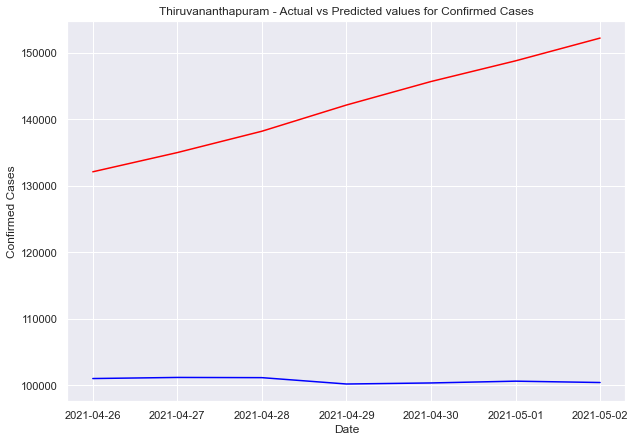

In [36]:
plot_hbm_test(sorted_data_test, new_df_test_th, 'Thiruvananthapuram')

# Chennai

In [37]:
new_df_train_ch, new_df_test_ch, predicted_df_hbm_ch, district_ch = predicted_dataframe(sorted_data_train, sorted_data_test, ppc_hierarchical, 'Chennai')

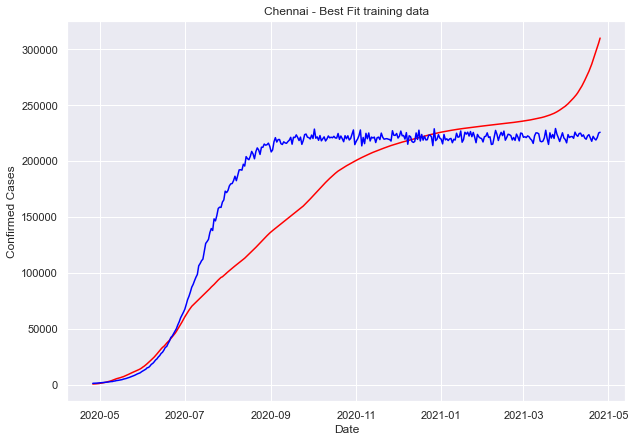

In [38]:
plot_hbm_train(sorted_data_train, new_df_train_ch, 'Chennai')

In [39]:
print("Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in", district_ch)
predicted_df_hbm_ch.reset_index(drop = True)

Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in Chennai


,Date,Actual Confirmed,Predicted Confirmed,Absolute Error,Accuracy,% of incorrect prediction
0,2021-04-26,314074,221027,93047,70.374179,29.625821
1,2021-04-27,318614,218747,99867,68.655803,31.344197
2,2021-04-28,323452,222777,100675,68.874825,31.125175
3,2021-04-29,328520,221729,106791,67.493303,32.506697
4,2021-04-30,333804,219007,114797,65.609459,34.390541
5,2021-05-01,339797,224440,115357,66.051201,33.948799
6,2021-05-02,345966,218324,127642,63.105623,36.894377


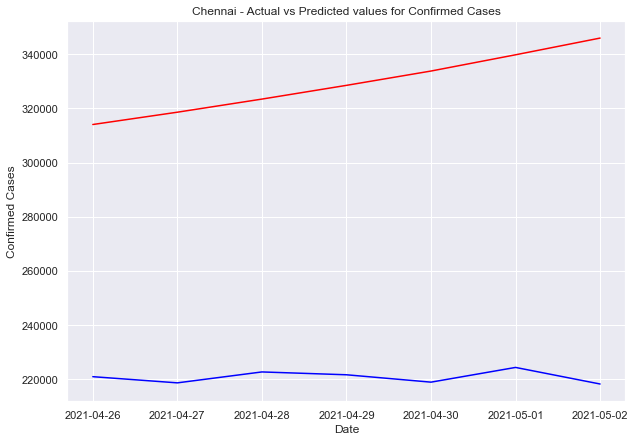

In [40]:
plot_hbm_test(sorted_data_test, new_df_test_ch, 'Chennai')

# Mumbai

In [41]:
new_df_train_mu, new_df_test_mu, predicted_df_hbm_mu, district_mu = predicted_dataframe(sorted_data_train, sorted_data_test, ppc_hierarchical, 'Mumbai')

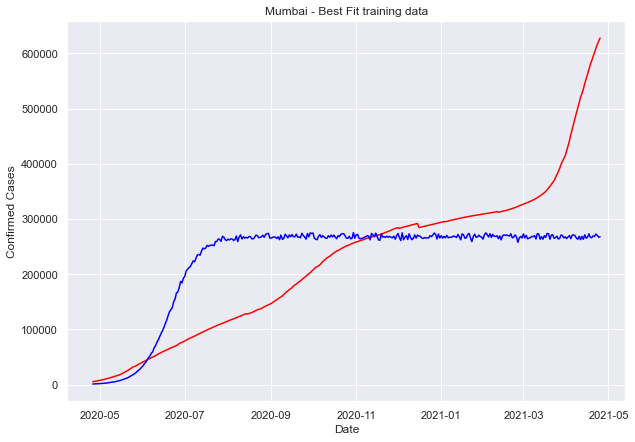

In [42]:
plot_hbm_train(sorted_data_train, new_df_train_mu, 'Mumbai')

In [43]:
print("Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in", district_mu)
predicted_df_hbm_mu.reset_index(drop = True)

Actual confirmed, predicted confirmed, absolute error, accuracy, % of incorrect prediction for 7 days in Mumbai


,Date,Actual Confirmed,Predicted Confirmed,Absolute Error,Accuracy,% of incorrect prediction
0,2021-04-26,631484,270045,361439,42.763554,57.236446
1,2021-04-27,635483,272186,363297,42.831358,57.168642
2,2021-04-28,640409,268879,371530,41.985512,58.014488
3,2021-04-29,644583,268358,376225,41.632808,58.367192
4,2021-04-30,648471,273459,375012,42.169812,57.830188
5,2021-05-01,652368,266172,386196,40.800898,59.199102
6,2021-05-02,655997,265722,390275,40.506588,59.493412


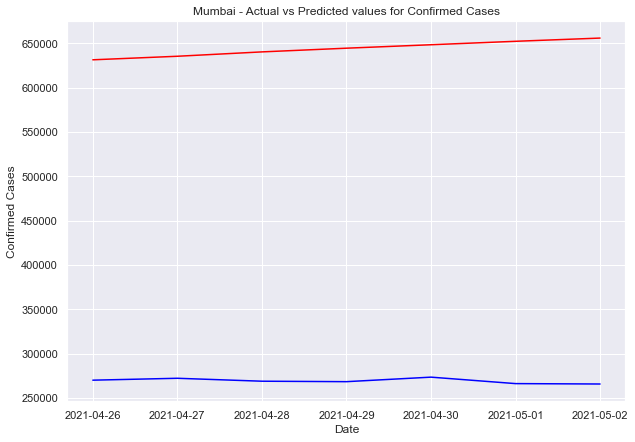

In [44]:
plot_hbm_test(sorted_data_test, new_df_test_mu, 'Mumbai')

In [45]:
# predicted_df_hbm_ben.reset_index(drop = True).to_csv("hbm_ben.csv")
# predicted_df_hbm_del.reset_index(drop = True).to_csv("hbm_del.csv")
# predicted_df_hbm_ch.reset_index(drop = True).to_csv("hbm_ch.csv")
# predicted_df_hbm_th.reset_index(drop = True).to_csv("hbm_th.csv")
# predicted_df_hbm_mu.reset_index(drop = True).to_csv("hbm_mu.csv")